In [2]:
# import packages
import pandas as pd
import numpy as np
import seaborn as sns
import math
import matplotlib.pyplot as plt
import pmdarima as pm
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.gofplots import qqplot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import boxcox
import warnings
from tqdm import tqdm 
from time import sleep
%matplotlib inline

In [3]:
# read dataframe from covid_explore.ipynb output
covid = pd.read_csv("./data/covid/covid19_20210104_mod.csv", index_col='date', parse_dates=True)

In [4]:
covid.head()

,days_elapse,new_count_update,new_deaths_update,new_recover_update,new_numtotal,new_numdeaths,new_numrecover
date,,,,,,,
2020-01-31,0,1.0,0.0,0.0,1.0,0.0,0.0
2020-02-01,1,0.0,0.0,0.0,1.0,0.0,0.0
2020-02-02,2,0.0,0.0,0.0,1.0,0.0,0.0
2020-02-03,3,0.0,0.0,0.0,1.0,0.0,0.0
2020-02-04,4,0.0,0.0,0.0,1.0,0.0,0.0


In [72]:
# select columns of interest and remove all dates up to March 1
# from the start of the pandemic in BC
covid_mod = covid.loc['2020-03-01':,('days_elapse', 'new_count_update')].copy()
covid_mod.columns = ['days_elapse', 'daily_case']
covid_mod['days_elapse'] = (covid_mod.index - pd.to_datetime('2020-03-01')).days

# add a 3, 5, 7-day rolling mean
covid_mod['daily_case_3mean'] = covid_mod['daily_case'].rolling(window = 3).mean()
covid_mod['daily_case_5mean'] = covid_mod['daily_case'].rolling(window = 5).mean()
covid_mod['daily_case_7mean'] = covid_mod['daily_case'].rolling(window = 7).mean()

In [23]:
covid_mod.head(20)

,days_elapse,daily_case,daily_case_3mean,daily_case_5mean,daily_case_7mean,daily_case_14mean,daily_case_14stdev
date,,,,,,,
2020-03-01,0,1.0,NaN,NaN,NaN,NaN,NaN
2020-03-02,1,2.0,NaN,NaN,NaN,NaN,NaN
2020-03-03,2,2.0,1.666667,NaN,NaN,NaN,NaN
2020-03-04,3,4.0,2.666667,NaN,NaN,NaN,NaN
2020-03-05,4,5.0,3.666667,2.8,NaN,NaN,NaN
2020-03-06,5,3.0,4.000000,3.2,NaN,NaN,NaN
2020-03-07,6,3.0,3.666667,3.4,2.857143,NaN,NaN
2020-03-08,7,2.0,2.666667,3.4,3.000000,NaN,NaN
2020-03-09,8,3.0,2.666667,3.2,3.142857,NaN,NaN


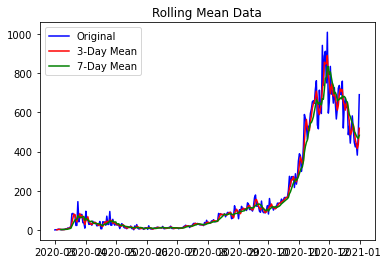

In [25]:
# compare the 3-day and 7-day mean with the original dataset to check it makes sense
plt.plot(covid_mod.index, covid_mod['daily_case'], color = 'blue', label = 'Original')
plt.plot(covid_mod.index, covid_mod['daily_case_3mean'], color = 'red', label = '3-Day Mean')
plt.plot(covid_mod.index, covid_mod['daily_case_7mean'], color = 'green', label = '7-Day Mean')
plt.legend(loc = 'best')
plt.title('Rolling Mean Data')
plt.show()

In [73]:
# define a function to add various columns transformations to the dataframe
# includes: differencing, boxcox, differencing of boxcox, 2 week rolling normalization and differencing
def add_series(df, column):
    df_new = df[['days_elapse', column]].copy()
    # create a column for differences
    df_new['difference'] = df_new[column] - df_new[column].shift(1)
    # create a column with a box-cox transform
    df_new['boxcox'], lam = boxcox(df_new[column])
    # create a column with differences of box-cox transform
    df_new['boxcox_difference'] = df_new['boxcox'] - df_new['boxcox'].shift(1)
    # create a 2 week rolling normalized column
    df_new['14mean'] = df_new[column].rolling(window = 14).mean()
    df_new['14stdev'] = df_new[column].rolling(window = 14).std()
    df_new['2wknormal'] = (df_new[column] - df_new['14mean']) / df_new['14stdev']
    # create a column for difference of 2 week normalized column
    df_new["2wknormal_difference"] = df_new["2wknormal"] - df_new["2wknormal"].shift(1)
            
    print('Lambda of Box-Cox Transform: %f' % lam)
            
    return df_new

In [37]:
# function to reverse a box-cox transform
def boxcox_inverse(value, lam):
    if (lam * value + 1) <= 0:
        return 0
    if lam == 0:
        return math.exp(value)
    return math.exp(math.log(lam * value + 1) / lam)

In [74]:
# add the columns transformations to the dataset
covid_3day = add_series(covid_mod, column = 'daily_case_3mean')

Lambda of Box-Cox Transform: 8.472136


In [75]:
covid_3day.head()

,days_elapse,daily_case_3mean,difference,boxcox,boxcox_difference,14mean,14stdev,2wknormal,2wknormal_difference
date,,,,,,,,,
2020-03-01,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-02,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-03,2,1.666667,NaN,8.826132,NaN,NaN,NaN,NaN,NaN
2020-03-04,3,2.666667,1.0,479.474090,470.647958,NaN,NaN,NaN,NaN
2020-03-05,4,3.666667,1.0,7121.706744,6642.232654,NaN,NaN,NaN,NaN


In [76]:
# function to view plots of data
def explore_series(df, columns_explore, plot_lags=20):
    # Figure setup
    plt.figure(figsize = (22, 24))
    plot_cols = len(columns_explore)
    position = 0
    # create lists for output values from adfuller tests
    output_ADF = []
    output_pval = []
    output_crit1 = []
    output_crit5 = []
    output_crit10 = []
    output_labels = []
    
    # look at columns of interest
    for column in df:
        if column in columns_explore:
            # time history plot
            df[column].plot(ax = plt.subplot2grid((5, plot_cols), (0, position)), title = column)
            # histogram
            df[column].hist(ax = plt.subplot2grid((5, plot_cols), (1, position)))
            # qqplot to check normality
            qqplot(df[column], line='r', ax = plt.subplot2grid((5, plot_cols), (2, position)))
            # autocorrelation plot
            plot_acf(df[column].dropna(), lags=plot_lags, ax=plt.subplot2grid((5, plot_cols), (3, position)))
            # partial autocorrelation plot
            plot_pacf(df[column].dropna(), lags=plot_lags, ax=plt.subplot2grid((5, plot_cols), (4, position)))
            position += 1
            
            # run adfuller test and append results to lists
            result = adfuller(df[column].dropna())
            output_ADF.append(result[0])
            output_pval.append(result[1])
            output_crit1.append(result[4]['1%'])
            output_crit5.append(result[4]['5%'])
            output_crit10.append(result[4]['10%'])
            output_labels.append(column)
     
    # create dataframe for the adfuller results
    df_out = pd.DataFrame(columns=output_labels, index=['ADF_Statistic', 'p-value', 'Critical_1percent', 
                                                 'Critical_5_percent', 'Critical_10_percent'])
    df_out.iloc[0] = output_ADF
    df_out.iloc[1] = output_pval
    df_out.iloc[2] = output_crit1
    df_out.iloc[3] = output_crit5
    df_out.iloc[4] = output_crit10  
            
    plt.show()
    display(df_out)

In [77]:
col_explore = ['daily_case_3mean',  'difference', 'boxcox', 'boxcox_difference', '2wknormal', '2wknormal_difference']

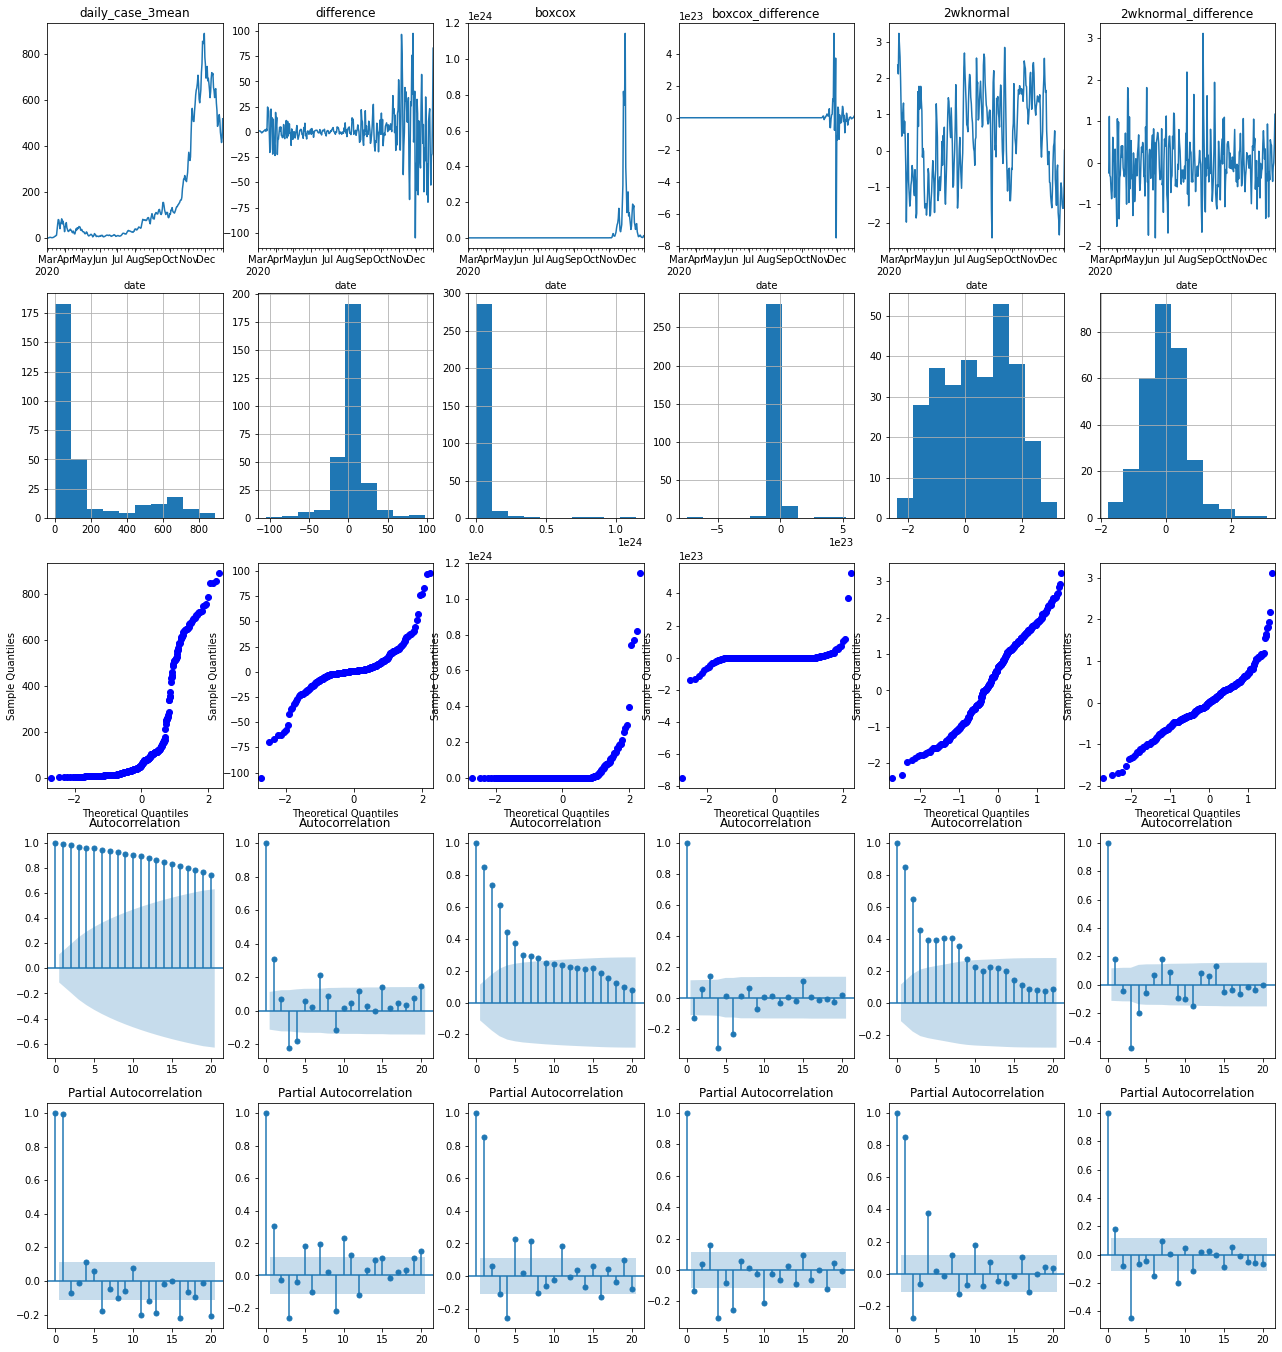

,daily_case_3mean,difference,boxcox,boxcox_difference,2wknormal,2wknormal_difference
ADF_Statistic,-0.980401,-3.181759,-2.856245,-8.003799,-2.897964,-7.066673
p-value,0.760345,0.021065,0.050678,0.0,0.045585,0.0
Critical_1percent,-3.453182,-3.453182,-3.452867,-3.452867,-3.453838,-3.454008
Critical_5_percent,-2.871593,-2.871593,-2.871455,-2.871455,-2.871881,-2.871956
Critical_10_percent,-2.572127,-2.572127,-2.572053,-2.572053,-2.57228,-2.57232


In [78]:
explore_series(covid_3day, col_explore)

In [100]:
from pmdarima import model_selection
train, test = model_selection.train_test_split(covid_3day[['2wknormal']].dropna().reset_index(drop=True), train_size=250)
arima = pm.auto_arima(train, 
                        error_action='ignore', 
                        trace=True,
                        suppress_warnings=True,
                        seasonal=False,
                        stepwise=True)





Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=478.467, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=520.359, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=514.719, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=514.798, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=518.402, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.34 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=484.964, Time=0.21 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=458.704, Time=0.19 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=458.452, Time=0.15 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=457.314, Time=0.08 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=514.861, Time=0.04 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=458.780, Time=0.07 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.46 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=455.403, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=512.904, Time

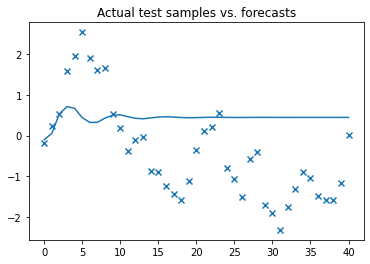

In [103]:
# Plot actual test vs. forecasts:
x = np.arange(test.shape[0])
plt.scatter(x, test, marker='x')
plt.plot(x, arima.predict(n_periods=test.shape[0]))
plt.title('Actual test samples vs. forecasts')
plt.show()

In [107]:
covid_3day

,days_elapse,daily_case_3mean,difference,boxcox,boxcox_difference,14mean,14stdev,2wknormal,2wknormal_difference
date,,,,,,,,,
2020-03-01,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-02,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-03,2,1.666667,NaN,8.826132e+00,NaN,NaN,NaN,NaN,NaN
2020-03-04,3,2.666667,1.000000,4.794741e+02,4.706480e+02,NaN,NaN,NaN,NaN
2020-03-05,4,3.666667,1.000000,7.121707e+03,6.642233e+03,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2020-12-27,301,461.000000,-52.666667,4.357557e+21,-6.538464e+21,576.309524,77.873277,-1.480733,-0.447710
2020-12-28,302,437.333333,-23.666667,2.788239e+21,-1.569319e+21,556.452381,75.090556,-1.586339,-0.105606
2020-12-29,303,415.666667,-21.666667,1.812893e+21,-9.753460e+20,539.285714,77.997464,-1.584911,0.001427


In [124]:
# calculate repeated train-test splits of time series data
def splitter(df, column, split_num):
    splits = TimeSeriesSplit(n_splits=split_num)
    plt.figure(figsize = (16, 2*split_num))
    index = 1
    for train_index, test_index in splits.split(df[column]):
        train = df[column][train_index]
        test = df[column][test_index]
        print('Split %d Observations: %d' % (index, (len(train) + len(test))))
        print('Training Observations: %d' % (len(train)))
        print('Testing Observations: %d' % (len(test)))
        plt.subplot(810 + index*2)
        plt.plot(train)
        plt.plot(test)
        index += 1
    plt.show()
    return splits

In [161]:
other = covid_3day.dropna().reset_index(drop=True).copy()

Split 1 Observations: 146
Training Observations: 74
Testing Observations: 72
Split 2 Observations: 218
Training Observations: 146
Testing Observations: 72
Split 3 Observations: 290
Training Observations: 218
Testing Observations: 72


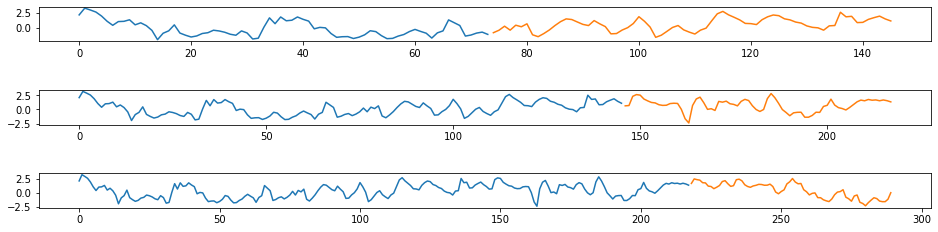

In [162]:
splits_3day = splitter(other, '2wknormal', 3)

In [136]:
# null model" persistance model
def persistence(train, test, label=""):
    name = 'pers_predict_' + label
    combine = pd.concat([train, test]).to_frame()
    combine.columns = ['test']
    combine[name] = combine['test'].shift()
    combine = combine.iloc[test.index]
    rmse = math.sqrt(mean_squared_error(combine[name], combine['test']))
    #print('RMSE: %.3f' % rmse)
    #combine.plot()
    #plt.show()
    return combine[[name]], rmse

In [137]:
# null model: rolling mean model
def roller(train, test, window_len=3, label=""):
    name = 'roll_predict_' + label
    combine = pd.concat([train, test]).to_frame()
    combine.columns = ['test']
    combine[name] = combine['test'].shift().rolling(window_len).mean()
    combine = combine.iloc[test.index]
    rmse = math.sqrt(mean_squared_error(combine[name], combine['test']))
    #print('RMSE: %.3f' % rmse)
    #combine.plot()
    #plt.show()
    return combine[[name]], rmse

In [149]:
# ARIMA model for a given order (p,d,q) 
# with number of steps to predict and optional confidence intervals
# uses a boxcox transform
def arima_model(data, arima_order, predict_steps = 1, confidence = False):
    # transform
    #transformed, lam = boxcox(data)
    #if lam < -5:
    #    transformed, lam = data, 1
    # predict    
    model = ARIMA(data, order=arima_order)
    model_fit = model.fit(disp=0)
    temp_results = model_fit.forecast(steps = predict_steps)
    yhat = temp_results[0]
    if confidence == True:
        ylow = temp_results[2].transpose()[0]
        yhigh = temp_results[2].transpose()[1]
    # invert transformed prediction
    predictions = [i for i in yhat]
    if confidence == True:
        low = [i for i in ylow]
        high = [i for i in yhigh]
        return predictions, low, high
    return predictions

In [146]:
# evaluate an ARIMA model using a rolling forward method
# with number of steps to predict and optional confidence intervals
def evaluate_arima_model(train, test, arima_order, label="", predict_steps = 1, confidence = False):
    name = []
    step_name = [('arima_predict_' + label + "_step" + str(i)) for i in np.arange(1,(predict_steps+1))]
    name.append(step_name)
    ### the label below is for a different type of prediction currently not in use
#   stepb_name = [('arima_predict_' + label + "_step" + str(i) + "b") for i in np.arange(2,(predict_steps+1))]
#   name.append(stepb_name)
    name = [val for sublist in name for val in sublist]
            
    history = [x for x in train]
    # make predictions
    predictions = []
    if confidence == True:
        low = []
        high = []
    for t in range(len(test)):
        if confidence == True:
            yhat, ylow, yhigh = arima_model(history, arima_order, predict_steps, confidence)
        else:
            yhat = arima_model(history, arima_order, predict_steps, confidence)

        ### uses the output from the previous model to run the next model
        ### currently not being used
#        for i in np.arange(1,predict_steps):
#            history.append(yhat[i-1])
#            temp_output = arima_model(history, arima_order, predict_steps = 1)
#            yhat.insert(i, temp_output[0])
            
#        if predict_steps > 1:
#            del history[-(predict_steps - 1):]
            
        predictions.append(yhat)
        if confidence == True:
            low.append(ylow)
            high.append(yhigh)
        # observation
        obs = test[t+test.index.min()]
        history.append(obs)
        #print('>Predicted=%.3f, Expected=%.3f' % (yhat, obs))
    # calculate out of sample error for the first step
    predictions = pd.DataFrame(predictions, index = test.index, columns = name)
    rmse = math.sqrt(mean_squared_error(test, predictions.iloc[:,0]))
    if confidence == True:
        low = pd.DataFrame(low, index = test.index, columns = name)
        high = pd.DataFrame(high, index = test.index, columns = name)
        return predictions, rmse, low, high
    return predictions, rmse

In [147]:
# evaluate the null models and the ARIMA model
# only for single step ARIMA evaluation
def evaluate_models(splits, df, data_col, arima_order):
    idx = 0
    out_data = df.copy()
    pers_rmse = []
    roll_rmse = []
    arima_rmse = []
    col_labels = []
    for train_index, test_index in splits.split(df[data_col]):
        idx += 1
        col_labels.append('split_' + str(idx))
        
        train = df[data_col][train_index]
        test = df[data_col][test_index]
        
        temp_results, temp_rmse = persistence(train, test, label = str(idx))
        out_data = pd.merge(out_data, temp_results, left_index = True, right_index = True, how = 'outer')
        pers_rmse.append(temp_rmse)
        
        temp_results, temp_rmse = roller(train, test, label = str(idx))
        out_data = pd.merge(out_data, temp_results, left_index = True, right_index = True, how = 'outer')
        roll_rmse.append(temp_rmse)
        
        temp_results, temp_rmse = evaluate_arima_model(train, test, arima_order, label = str(idx), predict_steps = 1)
        out_data = pd.merge(out_data, temp_results, left_index = True, right_index = True, how = 'outer')
        arima_rmse.append(temp_rmse)

        
    out_rmse = pd.DataFrame(columns=col_labels, index=['Persistence', 'Roller', 'ARIMA'])    
    out_rmse.iloc[0] = pers_rmse
    out_rmse.iloc[1] = roll_rmse
    out_rmse.iloc[2] = arima_rmse     
        
    return out_data, out_rmse

In [141]:
# plot to compare results from different prediction models
def compare_plot(df, index_col, labels, original):
    df_mod = df.set_index(index_col, drop = True)
    plot_rows = len(labels)
    plt.figure(figsize = (22, 4*plot_rows))
    position = 0 
    for label in labels:
        look_for = label + "|" + original
        include = df_mod.columns.str.contains(look_for, case=False)
        temp_df = df_mod.iloc[:, include]
        temp_df.plot(ax = plt.subplot2grid((plot_rows, 1), (position, 0)))
        position += 1
    plt.show()

In [163]:
# create a dataframe for the results of the models
covid_3day_results = other[['days_elapse', '2wknormal']].copy()

In [158]:
covid_3day_results

,days_elapse,2wknormal
0,15,2.351402
1,16,2.109531
2,17,3.224130
3,18,2.917304
4,19,2.576374
...,...,...
286,301,-1.480733
287,302,-1.586339
288,303,-1.584911
289,304,-1.155154


In [164]:
# evaluate models
covid_3day_results, rmse_results = evaluate_models(splits = splits_3day, df = covid_3day_results, data_col = '2wknormal', 
                                              arima_order = (3,1,0))

In [165]:
rmse_results

,split_1,split_2,split_3
Persistence,0.670616,0.759329,0.518551
Roller,0.927736,1.06141,0.71527
ARIMA,0.59709,0.634131,0.476584


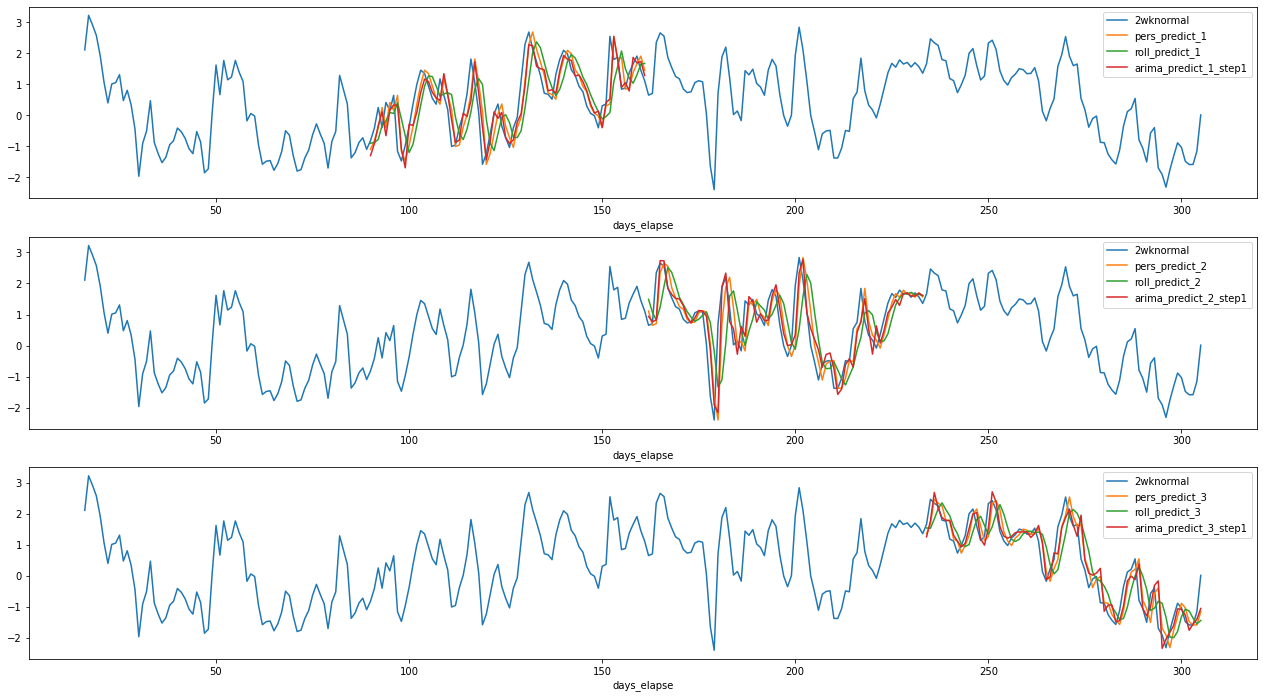

In [178]:
compare_plot(covid_3day_results, index_col = 'days_elapse', labels = ["_1", "_2", "_3"], original = '2wknormal')

In [173]:
# model multistep ARIMA forecast
# optional confidence interval which creates two additional output dfs
def multistep_forecast(splits, df, data_col, arima_order, forecast_steps, confidence = False):
    idx = 0
    out_data = df.copy()
    # create dataframes for the low and high confidence intervals if required
    if confidence == True:
        out_low_data = df.copy()
        out_high_data = df.copy()
    out_rmse = []
    col_labels = []
    index_labels = [("step" + str(i)) for i in np.arange(1,(forecast_steps+1))]
    for train_index, test_index in splits.split(df[data_col]):
        idx += 1
        col_labels.append('split_' + str(idx))

        train = df[data_col][train_index]
        test = df[data_col][test_index]
    
        if confidence == False:    
            temp_results, _ = evaluate_arima_model(train, test, arima_order, label = str(idx), 
                                                   predict_steps = forecast_steps, confidence = False)
        # include low and high confidence limits if required
        else:
            temp_results, _, low_temp, high_temp = evaluate_arima_model(train, test, arima_order, label = str(idx), 
                                                   predict_steps = forecast_steps, confidence = True)
            out_low_data = pd.merge(out_low_data, low_temp, left_index = True, right_index = True, how = 'outer')
            out_high_data = pd.merge(out_high_data, high_temp, left_index = True, right_index = True, how = 'outer')
            
        out_data = pd.merge(out_data, temp_results, left_index = True, right_index = True, how = 'outer')
    
        # shift the output step results to have the correct index
        # "start" is the column location of the first step
        start = 2 + (forecast_steps * (idx - 1))
        # create a temp dataframe to compare the rmse with the original data
        temp_rmse = []
        for i in np.arange(forecast_steps):
            out_data.iloc[:,start+i] = out_data.iloc[:,start+i].shift(i)
            # shift confidence limit dataframes if required
            if confidence == True:
                out_low_data.iloc[:,start+i] = out_low_data.iloc[:,start+i].shift(i)
                out_high_data.iloc[:,start+i] = out_high_data.iloc[:,start+i].shift(i)
            # create the temp df for rmse comparison and append calculated rmse    
            temp_df = pd.concat([out_data.iloc[:, start+i], out_data.loc[:,'2wknormal']], axis = 1)
            temp_df.dropna(inplace = True)
            rmse = math.sqrt(mean_squared_error(temp_df.iloc[:, 0], temp_df.iloc[:, 1]))
            temp_rmse.append(rmse)
    
        out_rmse.append(temp_rmse)
    
    out_rmse = pd.DataFrame(out_rmse).transpose()
    out_rmse.columns = col_labels
    out_rmse.set_index(pd.Index(index_labels), inplace = True)
    
    if confidence == False:
        return out_data, out_rmse
    else:
        return out_data, out_rmse, out_low_data, out_high_data

In [179]:
# create a dataframe for the forecast comparison results
covid_3day_forecast = other[['days_elapse', '2wknormal']].copy()

In [180]:
# evaluate a 3-day forecast
covid_3day_forecast, rmse_3day_results, low_conf, high_conf = multistep_forecast(splits = splits_3day, 
                                                                                 df = covid_3day_forecast, 
                                                                                 data_col = '2wknormal',
                                                                                 arima_order = (3,1,0), 
                                                                                 forecast_steps = 3, 
                                                                                 confidence = True)

In [38]:
covid_3day_forecast.tail()

,days_elapse,daily_case,arima_predict_1_step1,arima_predict_1_step2,arima_predict_1_step3,arima_predict_2_step1,arima_predict_2_step2,arima_predict_2_step3,arima_predict_3_step1,arima_predict_3_step2,arima_predict_3_step3
43,163,21.666667,NaN,NaN,NaN,NaN,NaN,NaN,14.689701,10.917134,11.106874
44,166,18.666667,NaN,NaN,NaN,NaN,NaN,NaN,20.867800,16.060914,11.202054
45,169,27.666667,NaN,NaN,NaN,NaN,NaN,NaN,20.656407,22.274827,16.261808
46,172,32.000000,NaN,NaN,NaN,NaN,NaN,NaN,25.483925,20.964256,22.952527
47,175,30.333333,NaN,NaN,NaN,NaN,NaN,NaN,32.271784,27.727189,21.921227


In [175]:
rmse_3day_results

,split_1,split_2,split_3
step1,0.597090,0.634131,0.476584
step2,0.917487,0.975326,0.730938
step3,1.206431,1.197161,0.930581


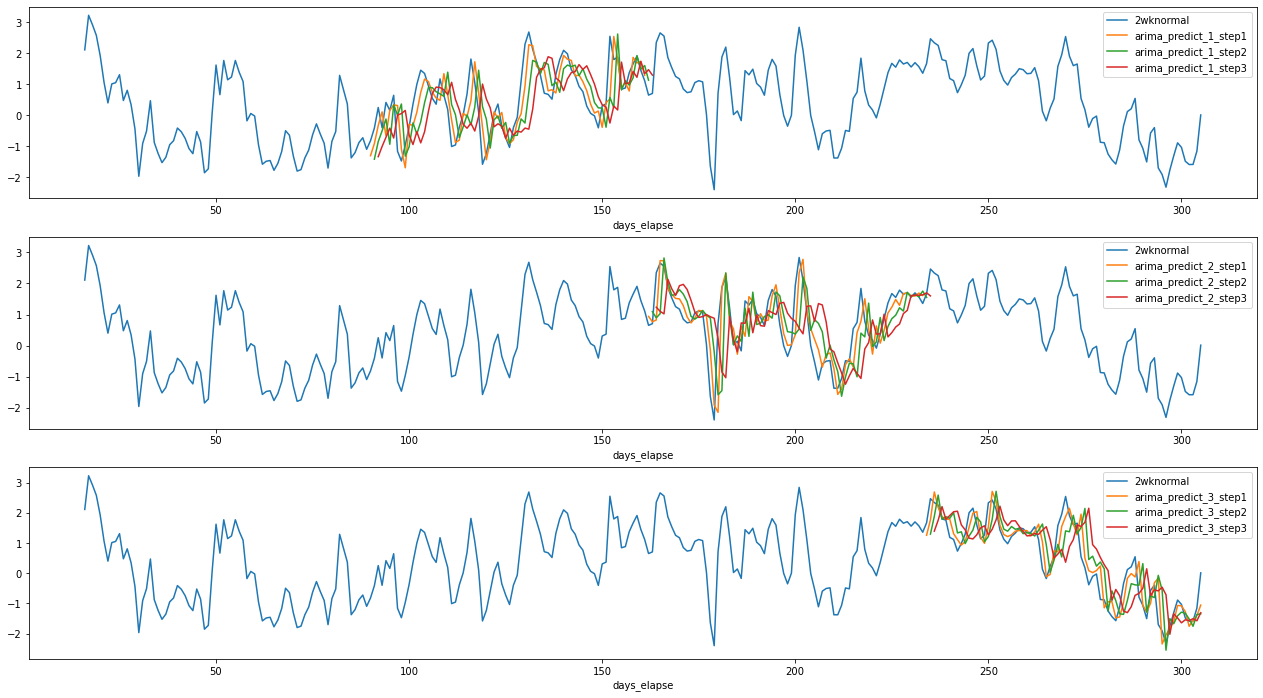

In [181]:
compare_plot(covid_3day_forecast, index_col = 'days_elapse', labels = ["_1", "_2", "_3"], original = '2wknormal')

In [176]:
# plot to compare results from different prediction models
def compare_conf(df, dflow, dfhigh, index_col, labels, original, step):
    df_mod = df.set_index(index_col, drop = True)
    dflow_mod = dflow.set_index(index_col, drop = True)
    dfhigh_mod = dfhigh.set_index(index_col, drop = True)
    plot_rows = len(labels)
    plt.figure(figsize = (22, 12))
    position = 0 
    for label in labels:
        look_for = (label + "_step" + str(step))
        include = df_mod.columns.str.contains((look_for+ "|" + original), case=False)
        include_low = dflow_mod.columns.str.contains(look_for, case=False)
        include_high = dfhigh_mod.columns.str.contains(look_for, case=False)
        temp_df = pd.concat((df_mod.iloc[:, include], dflow_mod.iloc[:, include_low], dfhigh_mod.iloc[:, include_high]), axis = 1)
        temp_df.plot(ax = plt.subplot2grid((plot_rows, 1), (position, 0)))
        position += 1
    plt.show()

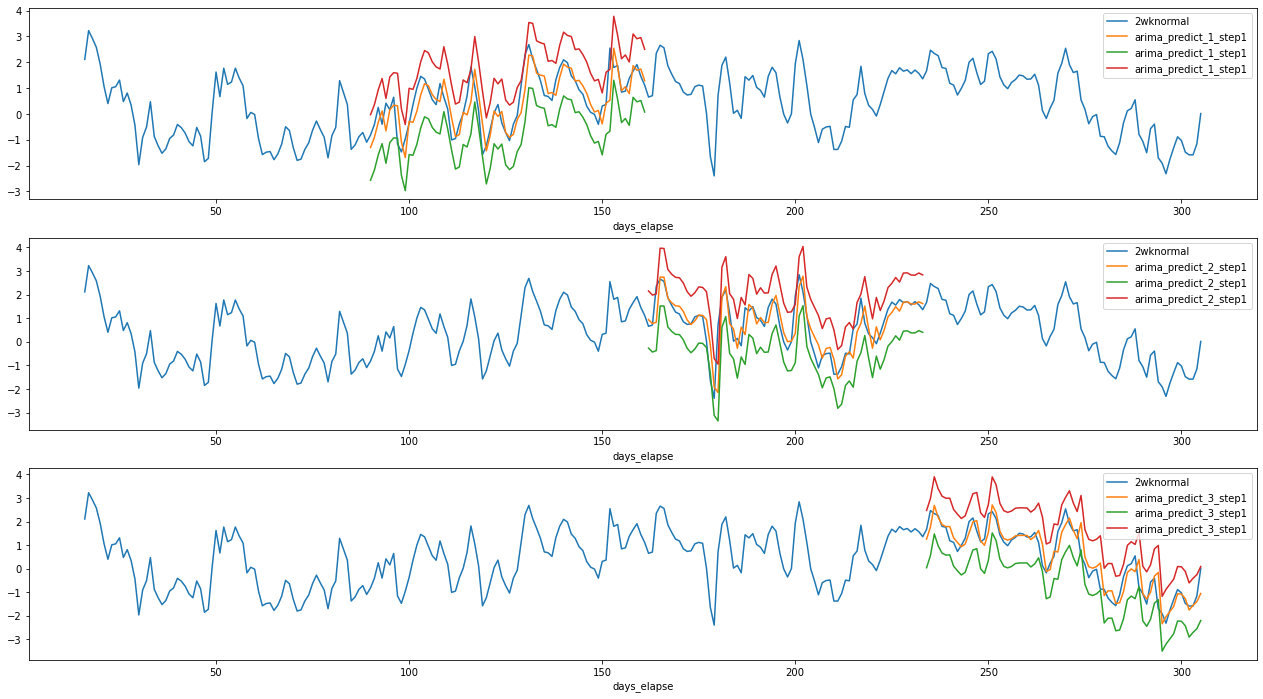

In [182]:
compare_conf(covid_3day_forecast, low_conf, high_conf, index_col = 'days_elapse', labels = ["_1", "_2", "_3"], original = '2wknormal', step = 1)

,days_elapse,2wknormal,arima_predict_1_step1,arima_predict_1_step2,arima_predict_1_step3,arima_predict_2_step1,arima_predict_2_step2,arima_predict_2_step3,arima_predict_3_step1,arima_predict_3_step2,arima_predict_3_step3
0,16,2.109531,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,17,3.224130,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,18,2.917304,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,19,2.576374,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,20,1.922266,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
285,301,-1.480733,NaN,NaN,NaN,NaN,NaN,NaN,-1.271293,-1.325551,-1.540497
286,302,-1.586339,NaN,NaN,NaN,NaN,NaN,NaN,-1.757268,-1.513503,-1.569544
287,303,-1.584911,NaN,NaN,NaN,NaN,NaN,NaN,-1.557013,-1.755790,-1.504429
288,304,-1.155154,NaN,NaN,NaN,NaN,NaN,NaN,-1.401649,-1.369223,-1.574048


In [188]:
pd.concat([covid_3day_forecast, covid_3day], keys = 'days_elapse', axis=1)

d                                  \
                    days_elapse 2wknormal arima_predict_1_step1   
0                          16.0  2.109531                   NaN   
1                          17.0  3.224130                   NaN   
2                          18.0  2.917304                   NaN   
3                          19.0  2.576374                   NaN   
4                          20.0  1.922266                   NaN   
...                         ...       ...                   ...   
2020-12-27 00:00:00         NaN       NaN                   NaN   
2020-12-28 00:00:00         NaN       NaN                   NaN   
2020-12-29 00:00:00         NaN       NaN                   NaN   
2020-12-30 00:00:00         NaN       NaN                   NaN   
2020-12-31 00:00:00         NaN       NaN                   NaN   

                                                                 \
                    arima_predict_1_step2 arima_predict_1_step3   
0                                     NaN                   NaN   
1                                     NaN                   NaN   
2                                     NaN                   NaN   
3                                     NaN                   NaN   
4                                     NaN                   NaN   
...                                   ...                   ...   
2020-12-27 00:00:00                   NaN                   NaN   
2020-12-28 00:00:00                   NaN                   NaN   
2020-12-29 00:00:00                   NaN                   NaN   
2020-12-30 00:00:00                   NaN                   NaN   
2020-12-31 00:00:00                   NaN                   NaN   

                                                                 \
                    arima_predict_2_step1 arima_predict_2_step2   
0                                     NaN                   NaN   
1                                     NaN                   NaN   
2                                     NaN                   NaN   
3                                     NaN                   NaN   
4                                     NaN                   NaN   
...                                   ...                   ...   
2020-12-27 00:00:00                   NaN                   NaN   
2020-12-28 00:00:00                   NaN                   NaN   
2020-12-29 00:00:00                   NaN                   NaN   
2020-12-30 00:00:00                   NaN                   NaN   
2020-12-31 00:00:00                   NaN                   NaN   

                                                                 \
                    arima_predict_2_step3 arima_predict_3_step1   
0                                     NaN                   NaN   
1                                     NaN                   NaN   
2                                     NaN                   NaN   
3                                     NaN                   NaN   
4                                     NaN                   NaN   
...                                   ...                   ...   
2020-12-27 00:00:00                   NaN                   NaN   
2020-12-28 00:00:00                   NaN                   NaN   
2020-12-29 00:00:00                   NaN                   NaN   
2020-12-30 00:00:00                   NaN                   NaN   
2020-12-31 00:00:00                   NaN                   NaN   

                                                                          a  \
                    arima_predict_3_step2 arima_predict_3_step3 days_elapse   
0                                     NaN                   NaN         NaN   
1                                     NaN                   NaN         NaN   
2                                     NaN                   NaN         NaN   
3                                     NaN                   NaN         NaN   
4                                     NaN                   NaN     